[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/marceloprates/Floral-Automata-Jupyter/blob/master/Floral%20Automata.ipynb) Notebook slightly modified from an existing Colab notebook

In [172]:

import numpy as np
import random
from IPython import display
import matplotlib.pyplot as plt


def neighbor_idx(world, x, y):
  friendgroup = world[(x-1 if x-1 >= 0 else x):(x+2), (y-1 if y-1 >= 0 else y):(y+2)]
  unaware = friendgroup == 0
  aware = friendgroup == 1
  participating = friendgroup == 2
  
  return unaware.sum(), aware.sum(), participating.sum()


def threestate_ca(world):
    N1 = world.shape[0]
    N2 = world.shape[1]
    for x in range(N1): #loop over one dimension
      for y in range(N2): #loop over two dimension
        n = neighbor_idx(world, x, y)
        if world[x, y] == 0: # this person doesnt know
          if n[2] + n[1] >= n[0]: # majority know
            world[x, y] = np.random.choice([0, 1, 2], 1, p=[0.5, 0.45, 0.05])
          elif n[2] + n[1] > 0: # some know
            world[x, y] = np.random.choice([0, 1, 2], 1, p=[0.8, 0.19, 0.01])
          else:
            pass # none know
        elif world[x, y] == 1: # this person doesnt care
          if n[1]+n[0] >= n[2]: # most of their friends dont care either
            world[x, y] = np.random.choice([1, 2], 1, p=[0.92, 0.08]) 
          else:
            world[x, y] = np.random.choice([1, 2], 1, p=[0.45, 0.55]) 
        else: # this person cares
          if n[2] >= n[1]+n[0]: # most of their friends care
            world[x, y] = np.random.choice([1, 2], 1, p=[0.01, 0.99]) 
          elif n[1]+n[0] > n[2]: # most of their friends dont care
            world[x, y] = np.random.choice([1, 2], 1, p=[0.2, 0.8]) 
          # else:
          #   pass # n[1] == n[2]
    

    return world


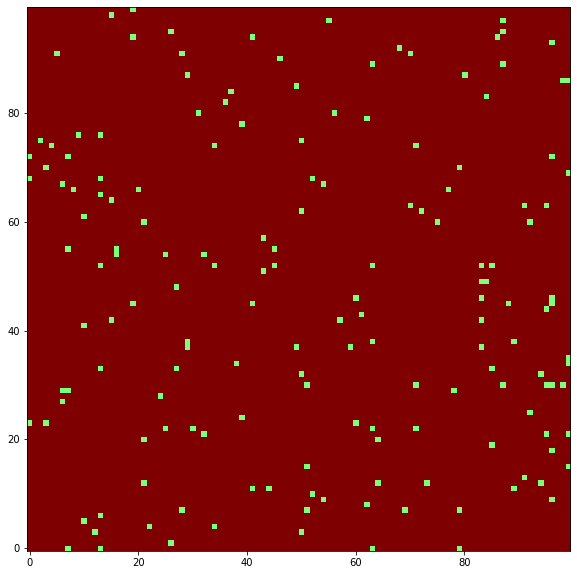

In [179]:
plt.rcParams["figure.figsize"] = (10,10)

world = np.random.choice([0, 1, 2], size=(100, 100), p=[0.95, 0.005, 0.045])
plt.imshow((world), origin = 'lower', cmap=plt.cm.jet, vmin = 0, vmax = 2)

ll = []
worlds=[]
for n in range(100):
  world = threestate_ca(world)
  plt.clf()
  img=plt.imshow((world), origin = 'lower', cmap=plt.cm.jet, vmin = 0, vmax = 2)
  display.display(plt.gcf())
  display.clear_output(wait=True)
  cnts = np.array([np.sum(world==0), np.sum(world==1), np.sum(world==2)])
  ll.append(cnts)

Text(0.5, 0, 'Timesteps')

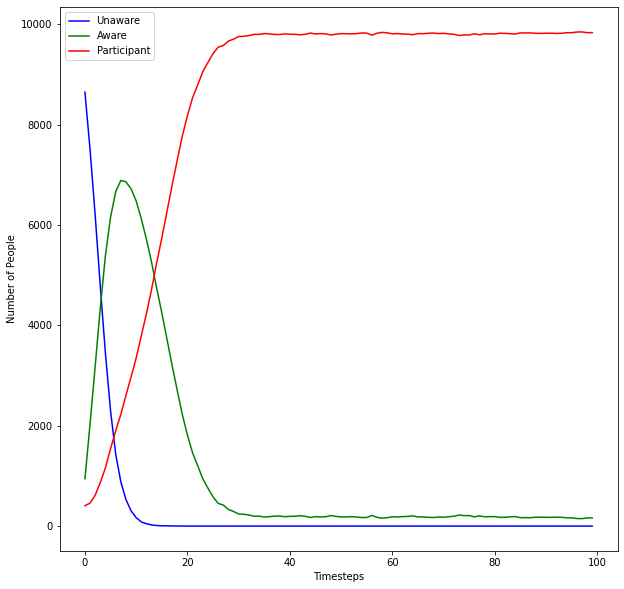

In [180]:
plt.plot(np.array(ll)[:, 0], label="Unaware",c="b" )
plt.plot(np.array(ll)[:, 1], label="Aware", c="g")
plt.plot(np.array(ll)[:, 2], label="Participant", c="r")
plt.legend()
plt.ylabel("Number of People")
plt.xlabel("Timesteps")

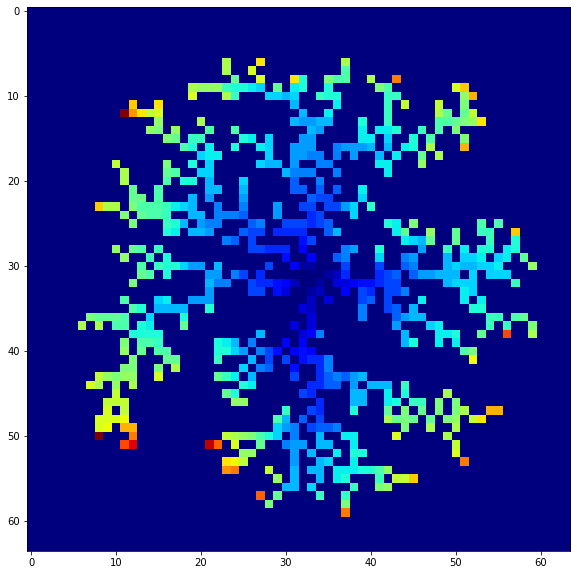

In [197]:
# DLA


def check_collide(particle_a, iter):
  for particle in particles:
    if not particle.moveable:
      if abs(particle_a.x - particle.x) <= 1 and abs(particle_a.y - particle.y) <= 1:
        particle_a.moveable = False
        particle_a.collide_iteration = iter
        seeds.append((particle_a.x, particle_a.y))
        break

class Particle:
  def __init__(self, moveable, x, y):
    self.moveable = moveable
    self.x = x
    self.y = y
    self.collide_iteration = 0
  def move(self, x, y, iter):
    if self.moveable:
      self.x = x
      self.y = y
      check_collide(self, iter)
    
def draw():
  for particle in particles:
    world[particle.x, particle.y] = 0 if particle.moveable else particle.collide_iteration
  plt.clf()
  plt.imshow(world, cmap=plt.get_cmap("jet"))
  display.display(plt.gcf())
  
  display.clear_output(wait=True)
  return world

#SEEDS = [(25, 25), (75, 75), (25, 75), (75, 25)]
SEEDS = [(64//2, 64//2)]
seeds = SEEDS
N_PARTICLES = 1000
WORLD_X, WORLD_Y = 64, 64
STEPS = 100

particles = [Particle(True, np.random.randint(0, WORLD_X), np.random.randint(0, WORLD_Y)) for _ in range(N_PARTICLES)]
particles += [Particle(False, x, y) for x,y in SEEDS] # add seed pts
world = np.zeros((WORLD_Y, WORLD_X))

def random_step(particle, world):
  return np.random.choice([(particle.x - 1)%world.shape[0], (particle.x + 1)%world.shape[0]]), np.random.choice([(particle.y - 1)%world.shape[0], (particle.y + 1)%world.shape[0]])

# implementing speed up as bias that directs our random walker towards an aggregated cluster
def towards_nearest_seed(particle, world):
  min_d = np.inf 
  min_ind = 0
  for n, seed in enumerate(seeds):
    d = np.sqrt(abs(seed[0] - particle.x) + abs(seed[1] - particle.y))
    if d < min_d:
      min_d = d
      min_ind = n
  if seeds[min_ind][0] > particle.x:
    x_to_go = particle.x + 1
  elif seeds[min_ind][0] < particle.x:
    x_to_go = particle.x - 1
  else:
    x_to_go = particle.x

  if seeds[min_ind][1] > particle.y:
    y_to_go = particle.y + 1
  elif seeds[min_ind][1] < particle.y:
    y_to_go = particle.y - 1
  else:
    y_to_go = particle.y
  if np.random.random() > 0.5:
    return np.random.choice([(particle.x - 1)%world.shape[0], (particle.x + 1)%world.shape[0]]), np.random.choice([(particle.y - 1)%world.shape[0], (particle.y + 1)%world.shape[0]])
  return x_to_go, y_to_go
  

def step(world, iter):
  for particle in particles:
    if particle.moveable:
      particle.move(*towards_nearest_seed(particle, world), iter)
  return draw()

for i in range(STEPS):
    world = step(world, i)



In [184]:
world[world > 0] = 1

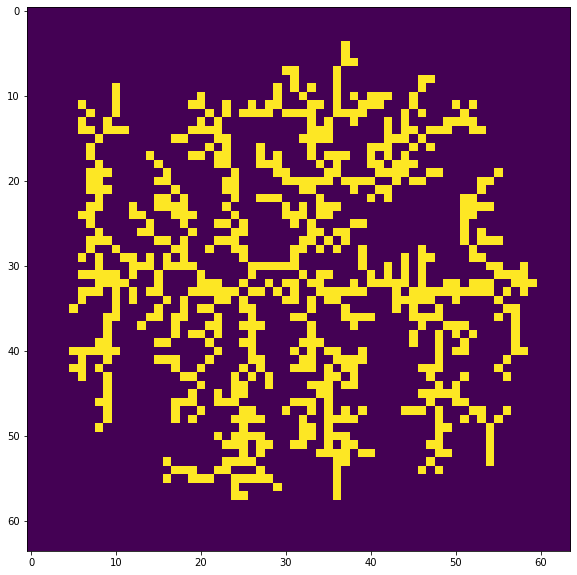

In [190]:
plt.imshow(world)

In [188]:
cnts = []
for lev in range(7):
    block_size = 2**lev
    cnt = 0
    for j in range(int(64/(block_size))):
        for i in range(int(64/block_size)):
            cnt = cnt + world[j*block_size:(j+1)*block_size, i*block_size:(i+1)*block_size].any()
    cnts.append(cnt)

data = np.array([(2**((k)),cnts[k]) for k in range(7)])


[727, 392, 150, 48, 16, 4, 1]

In [189]:
data

array([[  1, 727],
       [  2, 392],
       [  4, 150],
       [  8,  48],
       [ 16,  16],
       [ 32,   4],
       [ 64,   1]])

Text(0, 0.5, 'Log10 of Number of Boxes Needed to Cover Structure')

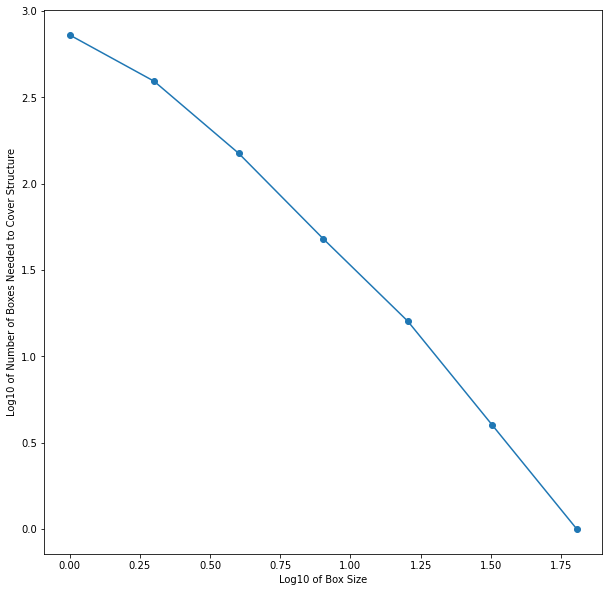

In [195]:
xs = np.log10(data[:,0])
ys = np.log10(data[:,1])
plt.scatter(xs,ys)
plt.plot(xs,ys)
plt.xlabel('Log10 of Box Size')
plt.ylabel('Log10 of Number of Boxes Needed to Cover Structure')


In [201]:
slope, intercept = np.polyfit(xs,ys,1)
slope

-1.6062740371601816